In [152]:
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt

In [153]:
import sqlalchemy as sal

endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"

# endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
# user="group3"
# db="db1"
pw="3qLXGOaxMSoqYfj3yAOY"

engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

In [154]:
cases = '''select record_date,new_cases from traffic_covid_both'''
cases = engine.execute(cases).fetchall()

import datetime
import pandas as pd

fromtime = datetime.datetime.strptime('01-01-2020','%m-%d-%Y')
cases = pd.DataFrame(cases)
cases[0] = pd.to_datetime(cases[0])
cases.set_index(0,inplace = True)
cases.fillna(0,inplace = True)
cases = cases[cases.index <= '2020-06-29']
covid = cases.fillna(0.).to_numpy().astype('float32')

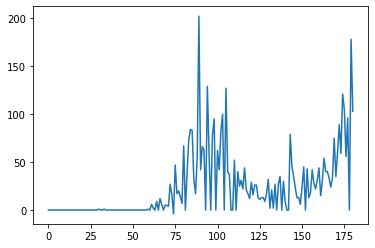

In [155]:
plt.plot(covid)

In [156]:
import numpy as np

covid_horizon = 7

x = []
y = []

for i in range(covid_horizon,len(covid)):
    x.append(covid[i-covid_horizon:i])
    y.append(covid[i])
    
x = np.array(x)
y = np.array(y)
x = torch.tensor(x).permute(1,0,2)
y = torch.tensor(y)

batch_size = 110

train_x,train_y = x[:,:batch_size,:], y[:batch_size,:]

test_x,test_y = x[:,batch_size:,:],y[batch_size:,]

In [157]:
import torch
import torch.nn as nn

# Timestep information already encoded in this sequence (Sequence Length)

class CovidEncoder(nn.Module):
    def __init__(self, input_dim, hidden_size,cell_type = 'lstm',seq_len = 7):
        super().__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        
        if cell_type == 'lstm':
            self.cell = nn.LSTM(input_size = input_dim,hidden_size= hidden_size)
        else:
            self.cell = nn.GRU(input_size = input_dim,hidden_size= hidden_size)
            
        self.lin = nn.Linear(seq_len * hidden_size,1)

    def forward(self, inputs): #, hidden_state):
        #output, hidden = self.cell(inputs, hidden_state)
        output, hidden = self.cell(inputs) #, hidden_state)
        output = output.view(-1, self.seq_len * self.hidden_size)
        #return torch.nn.functional.leaky_relu(self.lin(output[-1,:,:]))
        return torch.nn.functional.leaky_relu(self.lin(output))

Epoch number 0 loss value 19.019466
Epoch number 100 loss value 17.690786
Epoch number 200 loss value 16.025969
Epoch number 300 loss value 11.556612
Epoch number 400 loss value 10.356749
Epoch number 500 loss value 8.733968
Epoch number 600 loss value 7.208991
Epoch number 700 loss value 6.585490
Epoch number 800 loss value 6.181939
Epoch number 900 loss value 5.414775
Epoch number 1000 loss value 4.623538
Epoch number 1100 loss value 4.148813
Epoch number 1200 loss value 3.778704
Epoch number 1300 loss value 3.570579
Epoch number 1400 loss value 3.590845
Epoch number 1500 loss value 3.546646
Epoch number 1600 loss value 3.358760
Epoch number 1700 loss value 3.501706
Epoch number 1800 loss value 3.373775
Epoch number 1900 loss value 3.394877


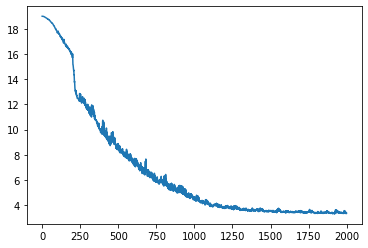

In [158]:
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 2000
input_dim = 1
hidden_size = 128

model = CovidEncoder(input_dim,hidden_size,seq_len = 7)
#h_0 = torch.randn(1,batch_size,hidden_size)

criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses = []
print_every = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    
    output = model(train_x) #,(h_0))
    loss = criterion(train_y,output)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % print_every == 0:
        print('Epoch number %d loss value %f'% (epoch,loss))

plt.plot(losses)
plt.show()

In [159]:
model.eval()

#h_0 = torch.zeros(1,batch_size,hidden_size)

with torch.no_grad():
    losses  = []

    out = model(train_x) #,h_0)

    loss = criterion(out,train_y)

    print('Loss %f'%(loss.detach().item()))

Loss 3.340228


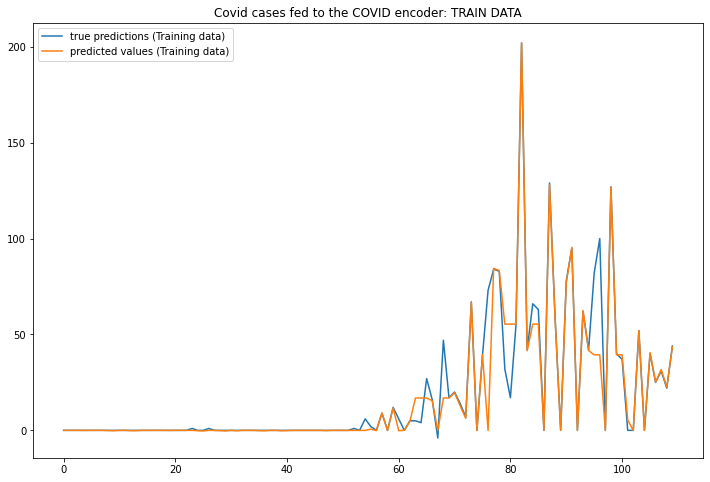

In [160]:
plt.figure(figsize =(12,8))
plt.title('Covid cases fed to the COVID encoder: TRAIN DATA')
plt.plot(train_y,label = 'true predictions (Training data)')
plt.plot(out,label = 'predicted values (Training data)')
plt.legend(loc = 'best')
plt.show()

In [161]:
model.eval()
criterion.eval()

#h_0 = torch.zeros(1,64,hidden_size)

with torch.no_grad():
    out = model(test_x) #,h_0)
    loss = criterion(out,torch.tensor(test_y))
    print('Loss %f'%(loss))

Loss 25.282574


<ipython-input-161-2f232d5fdee1>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(out,torch.tensor(test_y))


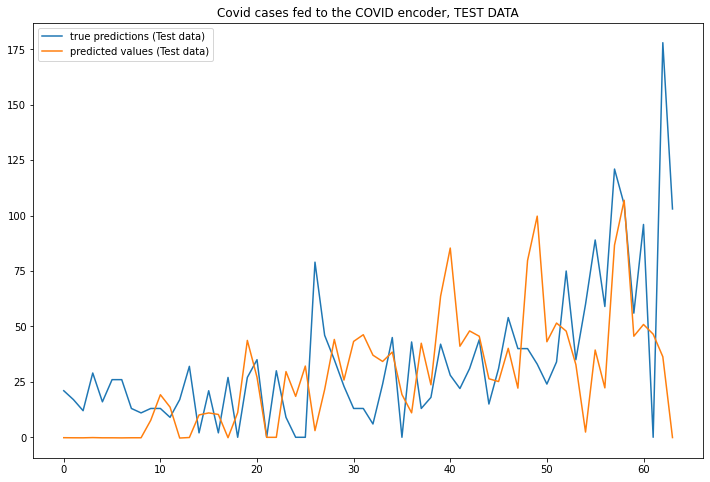

In [99]:
plt.figure(figsize =(12,8))
plt.title('Covid cases fed to the COVID encoder, TEST DATA')
plt.plot(test_y,label = 'true predictions (Test data)')
plt.plot(out,label = 'predicted values (Test data)')
plt.legend(loc = 'best')
plt.show()

In [96]:
### Now that we have a good encoder
import pandas as pd

merged_df = pd.read_pickle('traffic_covid.pkl')

### Null value cleaning still pending

In [97]:
from datetime import datetime

def convert_to_date(ind):
    return datetime.strptime(str(merged_df.index[ind].date()), '%Y-%m-%d')

def return_case_index(ind):
    #print(convert_to_date(ind))
    return cases.index.get_loc(convert_to_date(ind))

def relu(arr):
    arr[arr < 0] = 0.
    return arr

In [104]:
num_samples, num_nodes = (merged_df.shape[0],merged_df.shape[1] - 1)

cov_horizon = 7 

x_offsets = np.sort(np.concatenate((np.arange(-11, 1, 1),)))
y_offsets = np.sort(np.arange(1, 13, 1))

min_t = abs(min(x_offsets))
max_t = abs(num_samples - abs(max(y_offsets)))

cov_x = []
cov_y = []

for t in range(min_t, max_t):
    try:
        cind = return_case_index(t)
        cov_x.append(cases.values[relu(np.arange(cind-cov_horizon,cind))])
        cov_y.append(cases.values[cind])
    except IndexError as e:
        print(relu(np.arange(t-cov_horizon,t)))

In [105]:
covid_cases = np.stack(cov_x,axis = 0).astype('float32')
covid_labels = np.stack(cov_y,axis = 0).astype('float32')

In [117]:
cc_test.shape

torch.Size([7, 12091, 1])

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cc = torch.tensor(covid_cases[:40000]).permute(1,0,2)#.to(device)
cl = torch.tensor(covid_labels[:40000])#.to(device)

cc_test = torch.tensor(covid_cases[40000:]).permute(1,0,2)#.to(device)
cl_test = torch.tensor(covid_labels[40000:])#.to(device)

def get_batch(batch_size,dataset = 'train'):
    if dataset == 'train':
        for i in range(0,len(cc),batch_size):
            x,y = cc[:,i:i+batch_size,:],cl[i:i+batch_size,:]
            if x.shape[1] == batch_size:
                yield x,y
    else:
        for i in range(0,len(cc_test),batch_size):
            x,y = cc_test[:,i:i+batch_size,:],cl_test[i:i+batch_size,:]
            if x.shape[1] == batch_size:
                yield x,y

In [132]:
torch.manual_seed(0)

epochs = 1000
input_dim = 1
hidden_size = 64
batch_size = len(cc)

Epoch number 0 loss value 1284.073853
Epoch number 10 loss value 882.020264
Epoch number 20 loss value 784.971130
Epoch number 30 loss value 796.218628
Epoch number 40 loss value 779.624573
Epoch number 50 loss value 826.331970
Epoch number 60 loss value 724.014587
Epoch number 70 loss value 694.671692
Epoch number 80 loss value 614.107361
Epoch number 90 loss value 521.942871
Epoch number 100 loss value 537.929810
Epoch number 110 loss value 501.461090
Epoch number 120 loss value 462.332184
Epoch number 130 loss value 432.901398
Epoch number 140 loss value 408.650116
Epoch number 150 loss value 426.697296
Epoch number 160 loss value 418.885529
Epoch number 170 loss value 447.976288
Epoch number 180 loss value 450.156799
Epoch number 190 loss value 422.213104
Epoch number 200 loss value 407.799042
Epoch number 210 loss value 404.474701
Epoch number 220 loss value 417.239716
Epoch number 230 loss value 485.939880
Epoch number 240 loss value 427.730652
Epoch number 250 loss value 412.567

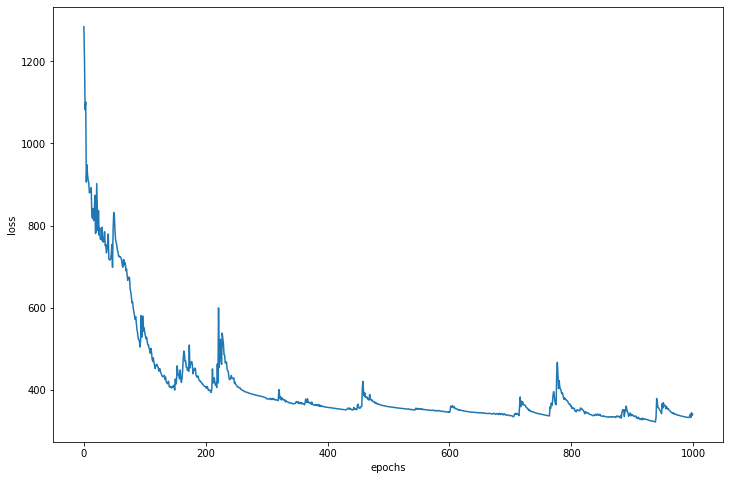

In [134]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = CovidEncoder(input_dim,hidden_size,seq_len = 7)
#model.to(device)
model.train()

#h_0 = torch.zeros(1,batch_size,hidden_size)#.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses = []
print_every = 10

train_x = cc
train_y = cl

train_x = train_x.to(device)
train_y = train_y.to(device)
model.to(device)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    output = model(train_x)

    loss = criterion(train_y,output)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())
    
    if epoch % print_every == 0:
        print('Epoch number %d loss value %f'% (epoch,losses[-1]))

plt.figure(figsize = (12,8))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

In [142]:
model.eval()

cc_test = cc_test.to(device)
cl_test = cl_test.to(device)

with torch.no_grad():
    out = model(cc_test)
    loss = criterion(out,cl_test)
    print('Loss %f'%loss.item())

Loss 2175.643799


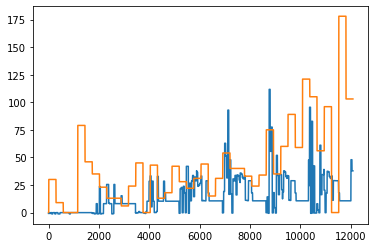

In [147]:
plt.plot(out.detach().cpu())
plt.plot(cl_test.detach().cpu())
plt.show()

In [148]:
model.eval()

cc = cc.to(device)
cl = cl.to(device)

with torch.no_grad():
    out = model(cc)
    loss = criterion(out,cl)
    print('Loss %f'%loss.item())

Loss 337.518250


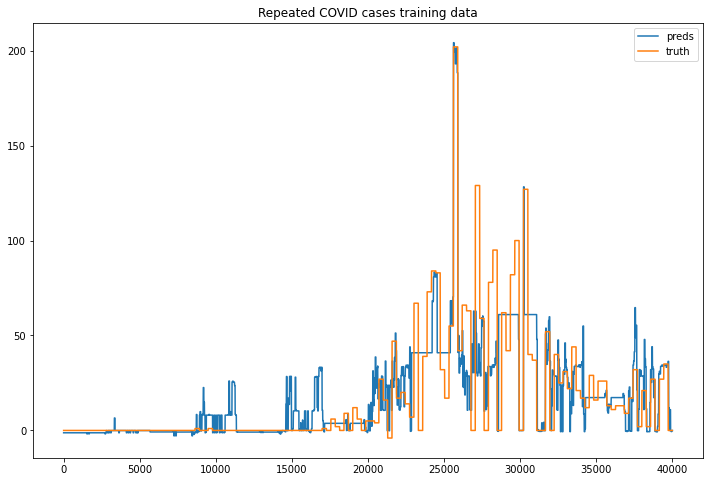

In [151]:
plt.figure(figsize = (12,8))
plt.plot(out.detach().cpu(),label ='preds')
plt.plot(cl.detach().cpu(),label = 'truth')
plt.title('Repeated COVID cases training data')
plt.legend(loc = 'best')
plt.show()